In [1]:
import pandas as pd
import dask.dataframe as dd

import imp

prepare_data = imp.load_source('prepare_data', '../src/prepare_data.py')
process_data = imp.load_source('processe_data', '../src/process_data.py')

In [2]:
import seaborn as sns
import numpy as np
import matplotlib

In [3]:
import matplotlib.pyplot as plt

In [4]:
font = {"size": 10, "weight": "bold"}
matplotlib.rc("font", **font)

In [5]:
color = matplotlib.cm.viridis(0.3)

In [160]:
color_c = matplotlib.cm.viridis(0.4)

**Top perfomances**

In [11]:
dfs = []
for name in ['standard', 'noise', 'probend', 'probend_noise']:
    df = pd.read_csv('../data/%s_3_processed.csv' % name, index_col=0
                           )
    df['type'] = name
    dfs.append(df)

**Descriptive measures**

In [161]:
[df.size for df in dfs]

[34171462, 35181650, 33171270, 34176460]

In [162]:
unique_number_of_seeds = len(dfs[0].seed.unique())
unique_number_of_seeds

11420

In [14]:
file = open('../paper/unique_number_of_seeds.tex', "w")
file.write("{}".format(unique_number_of_seeds))
file.close()

In [15]:
number_of_all_tournaments = sum([len(df.seed.unique()) for df in dfs])

In [16]:
file = open('../paper/number_of_all_tournaments.tex', "w")
file.write("{}".format(number_of_all_tournaments))
file.close()

In [171]:
np.mean(dfs[0].groupby(['Name']).count()['Rank'])

5180.634020618557

In [174]:
dfs[0][dfs[0]['Name'] == 'Tit For Tat']['seed'].count()

5114

**Top performances tables**

In [17]:
average_prfs = []
types = []
for df in dfs:
    types.append(df['type'].unique()[0])
    average_prfs.append(df.groupby(['Name']).median()['Normalized_Rank'].round(5))

In [31]:
columns = []
for prfs in average_prfs:
    columns.append(prfs.sort_values()[:15].index)
    columns.append(prfs.sort_values()[:15].values)

In [34]:
table = pd.DataFrame.from_records(columns,).T

In [37]:
table.columns = ['Name', r'$\bar{r}$'] * 4

In [40]:
file = open('../paper/perfomances_table.tex', "w")
file.write(table.to_latex())
file.close()

In [12]:
for prf, tps in zip(average_prfs, types):
    table = pd.DataFrame(prf.sort_values()[:15])
    table = table.rename(columns={'Normalized_Rank':
                                  r'$\bar{r}$ in %s tournaments' % tps})
    table.to_latex('../paper/performance_%s_table.tex' % tps)
    

In [41]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import gaussian_kde

%matplotlib inline

In [42]:
def get_distribution_without_outliers(distribution, percentage=0.1):
    distribution.sort()
    size_of_ditribution = len(distribution)
    outliers = int(size_of_ditribution * (percentage))
    
    return distribution[:-outliers]

**Top variation**

In [117]:
def plot_perfomance_violin_plots(type_index,
                                 tournament_type,
                                 top_names,
                                 ylim_up=1,
                                 remove_outliers=False,
                                 percentage=0.1):
    data, violin_data = [], []
    top_names.reverse()
    for name in top_names:
        distribution = dfs[type_index][dfs[type_index]['Name'] == name]['Normalized_Rank'].values
        
        data.append(distribution)
        
        if remove_outliers:
            distribution = get_distribution_without_outliers(distribution, percentage)
        violin_data.append(distribution)

    means = [np.mean(dt) for dt in data]

    fig, axes = plt.subplots(figsize=(10, 4))

    parts = axes.violinplot(violin_data, showextrema=False,
                            showmeans=False);

    boxes = axes.boxplot(data, showfliers=False)
    axes.scatter(range(1, len(means) + 1), means, marker='o', color='purple', zorder=3, s=50)

    for pc in parts['bodies']:
        pc.set_facecolor('lightsteelblue')
        pc.set_edgecolor('black')
        pc.set_alpha(.60)

    for bp in boxes['medians']:
        bp.set_color('purple')
        bp.set_linewidth(2)
        bp.set_linestyle('-.')
    for bp in boxes['caps']:
        bp.set_color('navy')
        bp.set_linewidth(2)
    for bp in boxes['whiskers']:
        bp.set_color('navy')
        bp.set_linewidth(2)
    for bp in boxes['boxes']:
        bp.set_color('navy')
        bp.set_linewidth(2)

    axes.set_ylabel(r'$r$')
    axes.set_ylim([0, ylim_up]);
    axes.set_xticklabels(list(top_names), rotation=90);

    fig.savefig('../images/performance_%s.pdf' % tournament_type,
                bbox_inches='tight')

In [47]:
tournament_types = ['standard', 'noisy', 'probabilistic ending', 'noisy probabilistic ending']

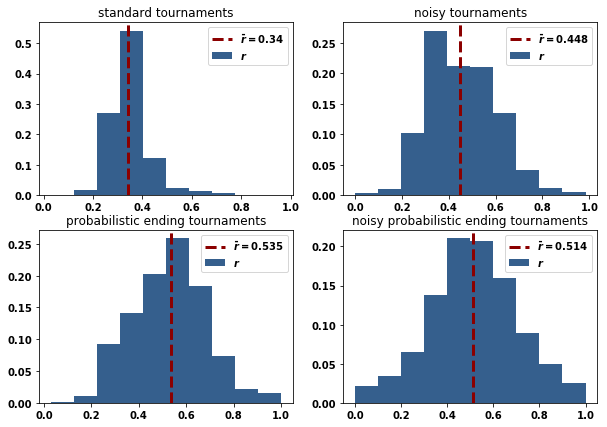

In [97]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))

for i in range(4):
    index = (int(i / 2), i % 2)

    values = dfs[i][dfs[i]['Name'] == 'Tit For Tat']['Normalized_Rank'].unique()
    weights = np.ones_like(values) / float(len(values))
    axes[index].hist(values, weights=weights, color=color, label=r'$r$')
    axes[index].axvline(
        np.median(values),
        color="darkred",
        linestyle="dashed",
        linewidth=3,
        label=r"$\bar{r}=%s$" % round(np.median(values), 3),
    )
    axes[inde]
    axes[index].set_title(r'%s tournaments' % tournament_types[i])
    axes[index].legend();
plt.savefig('../images/tit_for_tat_r_distributions.pdf', bbox_inches='tight')

**Standard tournaments**

In [118]:
np.mean(dfs[0]['size']), np.mean(dfs[0]['turns']), np.mean(dfs[0]['repetitions'])

(120.91104261210714, 100.92601212087443, 54.912377878359436)

In [119]:
len(dfs[0]['Name'].unique())

194

In [120]:
len(dfs[0][dfs[0]['Name'] == 'Tit For Tat'].seed.unique())

5112

In [121]:
len(dfs[0][dfs[0]['Name'] == 'Tit For Tat']['Normalized_Rank'].unique())

1358

In [122]:
np.mean(df.groupby(['Name', 'seed']).size().reset_index().groupby("Name").count()['seed'].values)

5161.561855670103

In [123]:
top_names = list(average_prfs[0].sort_values()[:15].index)

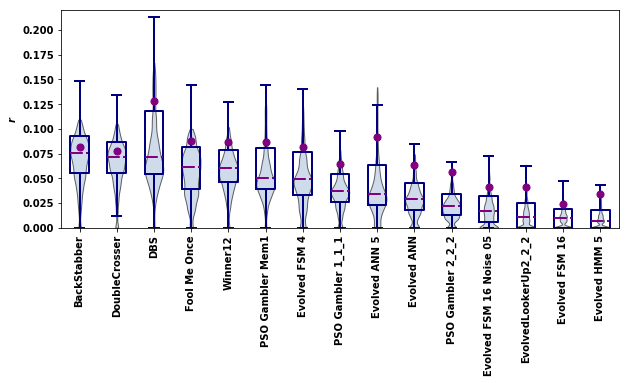

In [124]:
plot_perfomance_violin_plots(type_index=0,
                             tournament_type=types[0],
                             top_names=top_names,
                             ylim_up=0.22,
                             remove_outliers=True,
                             percentage=0.15)

**Noise**

In [125]:
np.mean(dfs[1]['size']), np.mean(dfs[1]['turns']), np.mean(dfs[1]['repetitions']), np.mean(dfs[1]['noise'])

(120.904945333718, 100.92148549030532, 54.915030989166226, 0.5035025565948674)

In [126]:
top_names_noise = list(average_prfs[1].sort_values()[:15].index)

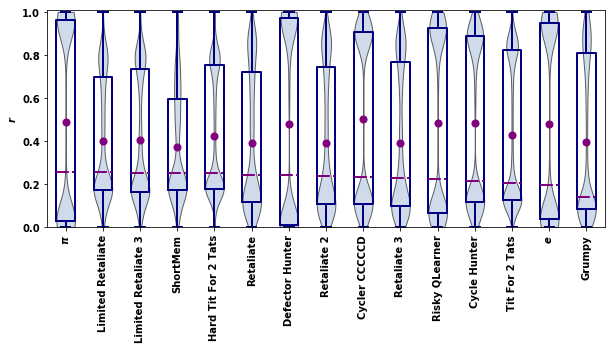

In [127]:
plot_perfomance_violin_plots(type_index=1,
                             tournament_type=types[1],
                             top_names=top_names_noise,
                             ylim_up=1.01)

**Probabilistic ending**

In [128]:
np.mean(dfs[2]['probend'])

0.4977798243241351

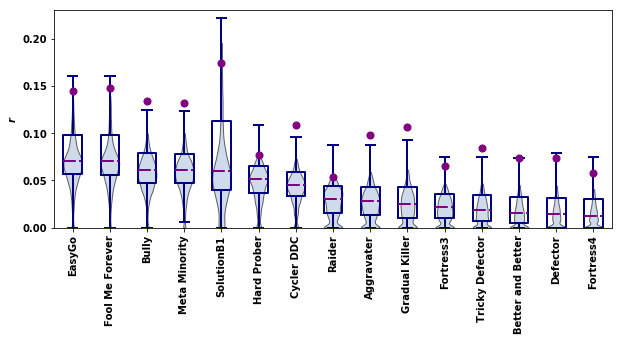

In [129]:
top_names_probend = list(average_prfs[2].sort_values()[:15].index)
plot_perfomance_violin_plots(type_index=2,
                             tournament_type=types[2],
                             top_names=top_names_probend,
                             ylim_up=.23,
                             remove_outliers=True,
                             percentage=0.17)

**Probend noisy**

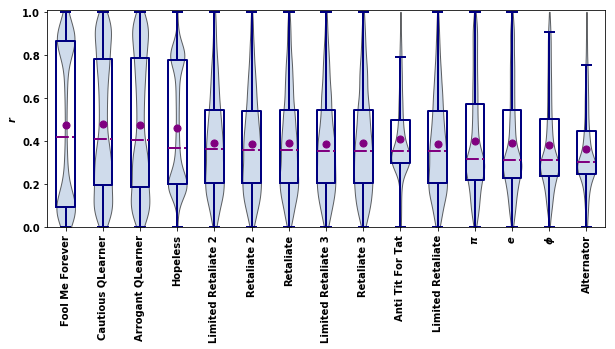

In [130]:
top_names_mixed = list(average_prfs[3].sort_values()[:15].index)
plot_perfomance_violin_plots(type_index=3,
                             tournament_type=types[3],
                             top_names=top_names_mixed,
                             ylim_up=1.01)

In [140]:
distributions = [dfs[-1][dfs[-1]['Name'] == name]['Normalized_Rank'].values for name in top_names_mixed]

In [141]:
import scipy.stats as stats

In [144]:
stats.f_oneway(*distributions)

F_onewayResult(statistic=124.77533668109541, pvalue=0.0)

**Overall**

In [148]:
dfs_j_rank = [df[['Normalized_Rank', 'Name']] for df in dfs]

In [153]:
ranks = pd.concat(dfs_j_rank).groupby(['Name']).median()['Normalized_Rank'].round(5)

In [159]:
file = open('../paper/performance_merged_table.tex', "w")
file.write(ranks.sort_values()[:15].to_latex())
file.close()

**Cooperating Ratios**

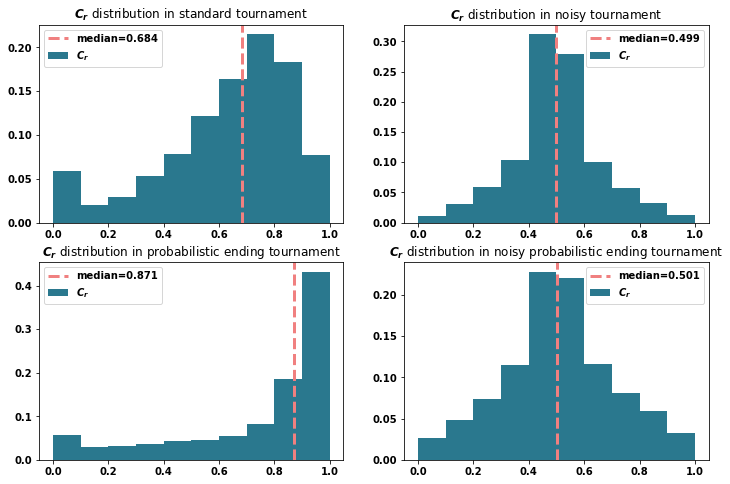

In [68]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

titles = ["standard", "noisy", "probabilistic ending", "noisy probabilistic ending"]
for i in range(4):
    index = (int(i / 2), i % 2)
    values = dfs[i]['Cooperation_rating']
    weights = np.ones_like(values) / float(len(values))
    axes[index].hist(values, weights=weights, color=color_c, label=r'$C_r$')
    axes[index].axvline(
        np.median(values),
        color="lightcoral",
        linestyle="dashed",
        linewidth=3,
        label="median=%s" % round(np.median(values), 3),
    )
    axes[index].set_title(r'$C_r$ distribution in %s tournament' % titles[i])
    axes[index].legend()
    
plt.savefig('../images/cooperation_ratings.pdf', bbox_inches='tight')